<a href="https://colab.research.google.com/github/Nadine305/Facial-Expression-Recognition/blob/main/Facial_Emotion_Recognition_using_Classical_Machine_Learning_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the data from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
import os
print(os.listdir(path))

['test', 'train']


# 1. preprocessing

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.6 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage import exposure

In [ ]:
def apply_clahe(img):
    """Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to the image."""
    img = np.uint8(img)  # Ensure uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)



In [ ]:
def denoise_image(img):
    """Apply a denoising filter (Gaussian blur) to the image."""
    return cv2.GaussianBlur(img, (5, 5), 0)



In [ ]:
def apply_histogram_stretching(img):
    """Apply histogram stretching to enhance image contrast."""
    min_val = np.min(img)
    max_val = np.max(img)
    if min_val == max_val:
        return img
    return ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)

In [ ]:


def normalize_image(img):
    """Normalize the image to a range of [0, 255] and ensure uint8 type."""
    return np.uint8(img)


In [ ]:

def sharpen_image(img):
    """Sharpen the image using a kernel filter."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

In [ ]:


def apply_gamma_correction(img, gamma=1.5):
    """Apply gamma correction to adjust brightness."""
    img = img / 255.0
    corrected = np.power(img, gamma)
    return np.uint8(np.clip(corrected * 255, 0, 255))


In [ ]:
def augment_image(img):
    augmented_images = []

    # Original
    augmented_images.append(img)

    # Horizontal flip
    flipped = cv2.flip(img, 1)
    augmented_images.append(flipped)

    # Rotation
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    augmented_images.append(rotated)

    # Brightness adjustment
    """brighter = cv2.convertScaleAbs(img, alpha=1.2, beta=30)
    augmented_images.append(brighter)"""

    return augmented_images


# 2.Feature Extraction

## 2.1 HOG Feature Extraction
 Histogram of oriented gradients

each block has 2*2 cells
each cell has 8*8 pixel

In [ ]:
def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [ ]:
def visualize_hog(img):
    features, hog_image = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis('off')
    plt.show()


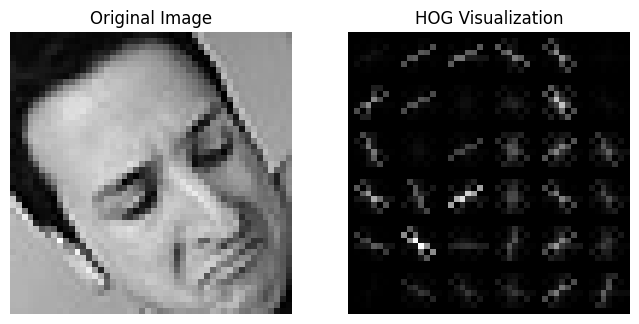

In [ ]:
img = cv2.imread("/kaggle/input/fer2013/train/disgust/Training_10371709.jpg", cv2.IMREAD_GRAYSCALE)
visualize_hog(img)

## 2.2 LBP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage import exposure

In [ ]:
def apply_lbp_extract_features(image_str, radius=1, n_points=8):



    # Change 'image' to 'image_str' which is the actual input parameter
    lbp = local_binary_pattern(image_str, P=n_points, R=radius, method='uniform')

    # Normalize LBP for better visualization
    lbp_normalized = exposure.rescale_intensity(lbp, in_range=(0, n_points + 2))
    return lbp_normalized

In [ ]:
def visualize_lbp(image):
    lbp=apply_lbp_extract_features(image, radius=1, n_points=8)
    # Plot original and LBP image side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original Image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # LBP Image
    axes[1].imshow(lbp, cmap='gray')
    axes[1].set_title(f"LBP Image ")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
img = cv2.imread("/kaggle/input/fer2013/train/disgust/Training_10371709.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
image_size = img.shape
print("Image size (height, width):", image_size)

Image size (height, width): (48, 48)


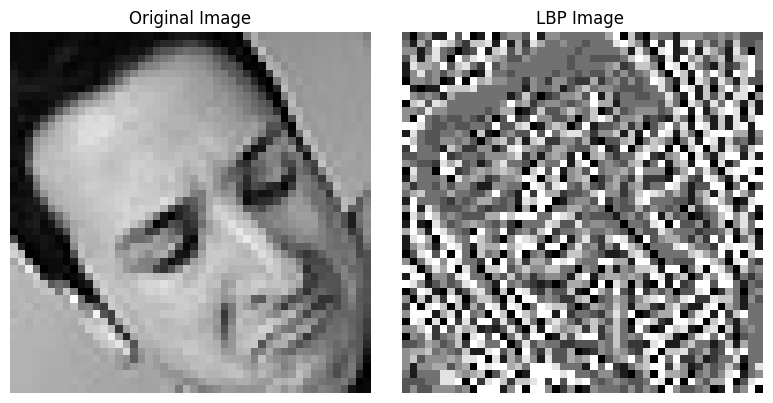

In [ ]:
lbp_result = apply_lbp_extract_features(img, radius=1, n_points=8)

visualize_lbp(img)

# Preprocessing + Feature Extraction


In [ ]:
def img_pre(img):
  processed_img = apply_clahe(img)
  processed_img = denoise_image(processed_img)
  processed_img = apply_histogram_stretching(processed_img)
  processed_img = apply_gamma_correction(processed_img, gamma=1.5)
  processed_img = sharpen_image(processed_img)
  processed_img = normalize_image(processed_img)


  lbp_features = apply_lbp_extract_features(processed_img, radius=1, n_points=8).flatten()
  hog_features = extract_hog_features(processed_img)
  combined_features = np.hstack([lbp_features, hog_features])
  return combined_features



In [ ]:
def load_and_preprocess_images(folder_path):
    """Load and preprocess images from a given folder."""
    features = []
    labels = []
    class_counts = {}

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            class_counts[label] = 0
            counter=0
            for img_name in os.listdir(label_path):
                counter+=1
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Warning: Skipped unreadable image {img_path}")
                    continue

                img = cv2.resize(img, (48, 48))
                if (label !='happy' and counter%3==0) or counter%7==0:
                  aug_img=augment_image(img)
                  for im in aug_img:
                    combined_features=img_pre(im)
                    features.append(combined_features)
                    labels.append(label)
                    class_counts[label] += 1
                else:
                  combined_features=img_pre(img)
                  features.append(combined_features)
                  labels.append(label)
                  class_counts[label] += 1









    print("Class distribution:", class_counts)
    return np.array(features), np.array(labels)

In [ ]:
train_folder = path+'/train'
test_folder = path+'/test'
print("Loading and preprocessing training images...")
X_train, y_train = load_and_preprocess_images(train_folder)


Loading and preprocessing training images...
Class distribution: {'surprise': 5889, 'fear': 7607, 'angry': 7417, 'neutral': 9221, 'sad': 8970, 'disgust': 810, 'happy': 9275}


In [ ]:
print("Loading and preprocessing testing images...")
X_test, y_test = load_and_preprocess_images(test_folder)

Loading and preprocessing testing images...
Class distribution: {'surprise': 831, 'fear': 1024, 'angry': 958, 'neutral': 1233, 'sad': 1247, 'disgust': 111, 'happy': 1774}


In [ ]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (35872, 3204)
Training labels shape: (35872,)
Testing data shape: (8978, 3204)
Testing labels shape: (8978,)


In [ ]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)

In [ ]:
X_train_res.shape

(12208, 3204)

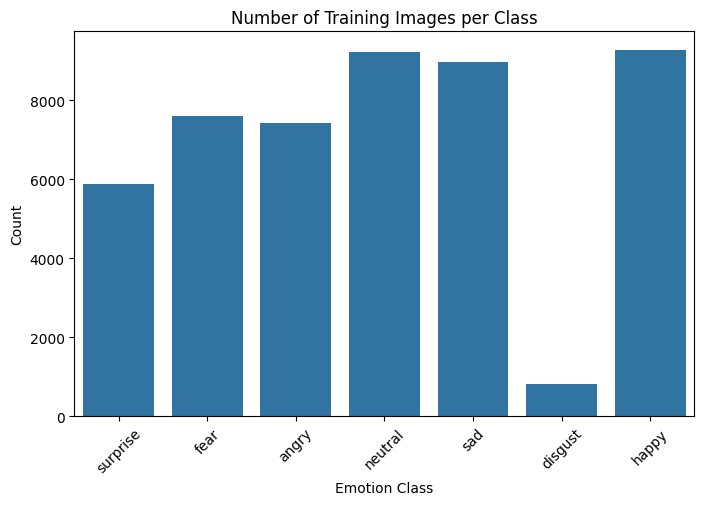

In [ ]:
import seaborn as sns
import pandas as pd

df_labels = pd.DataFrame({"label": y_train})
plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=df_labels)
plt.title("Number of Training Images per Class")
plt.xlabel("Emotion Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
y_train.shape

(35872,)

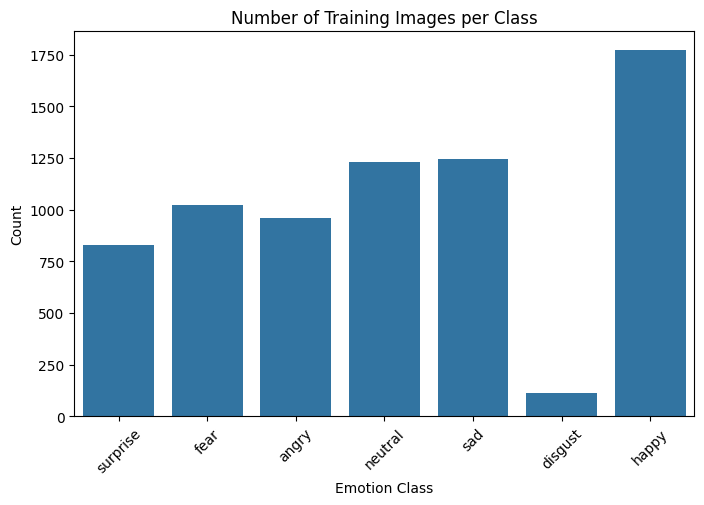

In [ ]:
import seaborn as sns
import pandas as pd

df_labels = pd.DataFrame({"label": y_test})
plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=df_labels)
plt.title("Number of Training Images per Class")
plt.xlabel("Emotion Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 3. classification

In [ ]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    # Dimensionality reduction
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)




In [ ]:
X_train_pca.shape

(14354, 300)

In [ ]:
X_train

array([[0.3       , 0.3       , 0.2       , ..., 0.00845515, 0.03521381,
        0.18587209],
       [0.        , 0.2       , 0.2       , ..., 0.03048971, 0.00775915,
        0.11221413],
       [0.8       , 0.8       , 0.8       , ..., 0.03365627, 0.05048946,
        0.01846   ],
       ...,
       [0.1       , 0.2       , 0.2       , ..., 0.01886409, 0.03638961,
        0.08422027],
       [0.8       , 0.8       , 0.8       , ..., 0.        , 0.        ,
        0.09952408],
       [0.        , 0.2       , 0.9       , ..., 0.08753947, 0.05240922,
        0.09127057]])

In [ ]:
X_test

array([[0.1       , 0.9       , 0.        , ..., 0.15181811, 0.        ,
        0.00604996],
       [0.        , 0.9       , 0.1       , ..., 0.06167237, 0.12773713,
        0.08688667],
       [0.8       , 0.8       , 0.8       , ..., 0.        , 0.06387056,
        0.02304507],
       ...,
       [0.8       , 0.8       , 0.8       , ..., 0.24683155, 0.24683155,
        0.14808374],
       [0.8       , 0.8       , 0.8       , ..., 0.        , 0.04593662,
        0.02579473],
       [0.3       , 0.5       , 0.5       , ..., 0.10280993, 0.15088952,
        0.2107219 ]])

In [ ]:
X_train_pca

array([[-6.42549930e+00,  1.83505415e+01,  6.80399899e+00, ...,
        -5.62428903e-01,  3.38852409e-01, -1.95864628e+00],
       [-3.93663950e+00, -1.41266391e+00, -7.36020969e+00, ...,
        -1.42564806e+00,  2.36677302e+00,  9.77132807e-01],
       [-4.42593522e+00,  6.70713198e+00, -8.36600612e+00, ...,
        -2.87383396e+00, -2.43272773e+00, -4.46410743e+00],
       ...,
       [-2.51718449e+00, -4.32931780e+00,  4.04191275e+00, ...,
        -1.36318053e+00, -1.74336764e+00,  2.13486627e-01],
       [ 1.84243980e+01,  1.29460993e+00,  3.57901495e+00, ...,
         4.69715740e-01,  2.37894573e+00, -1.05913435e+00],
       [ 1.88757408e+01,  3.55997778e+00, -8.31655803e-01, ...,
         1.02707084e+00, -2.91912630e-01, -7.26825754e-03]])

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.svm import LinearSVC


In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name='svm'):


    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    if model_name == 'svm':
        model = SVC(kernel='rbf', C=10, gamma=0.01, random_state=42,class_weight='balanced')
    elif model_name == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == 'knn':
        model = KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'mlp':
        model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
    else:
        raise ValueError("Unknown model name")

    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    """print(f"\nClassification Report for {model_name.upper()}:")
    print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))"""

    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix for {model_name.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model, accuracy_score(y_test_encoded, y_pred)

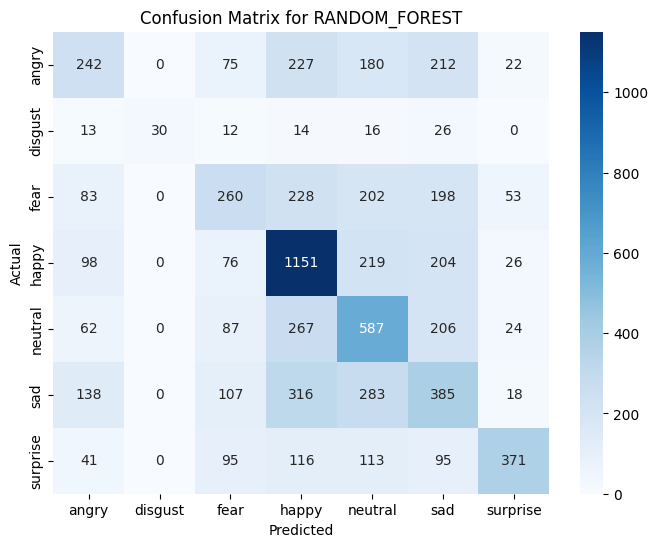

In [ ]:
#models = ['svm', 'random_forest', 'knn', 'mlp']
models = ['random_forest']

accuracies = {}

for model in models:
    _, accuracy = train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test, model)
    accuracies[model] = accuracy




In [ ]:
y_train.shape

# image display functions

In [ ]:
def load_raw_images(folder_path):
    """Load original grayscale images and labels from folder without preprocessing."""
    images = []
    labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Warning: Skipped unreadable image {img_path}")
                    continue

                images.append(img)
                labels.append(label)

    return images, labels


In [ ]:
def compare_before_after_preprocessing(img, preprocessed_img, label):
    """Compare an original image with its preprocessed version."""
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original - Label: {label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_img, cmap='gray')
    plt.title("Preprocessed")
    plt.axis('off')

    plt.show()

In [ ]:
def test_preprocessing_comparison(X, y, num_samples=5):
    """Display original and preprocessed images side by side."""
    for i in range(num_samples):
        original_img = X[i]

        preprocessed_img = apply_clahe(original_img)
        preprocessed_img = denoise_image(preprocessed_img)
        preprocessed_img = apply_histogram_stretching(preprocessed_img)
        preprocessed_img = apply_gamma_correction(preprocessed_img, gamma=1.5)
        preprocessed_img = sharpen_image(preprocessed_img)
        preprocessed_img = normalize_image(preprocessed_img)

        compare_before_after_preprocessing(original_img, preprocessed_img, y[i])

## Display original and preprocessed images side by side.


Testing preprocessing comparison on training samples...
Testing preprocessing comparison on testing samples...


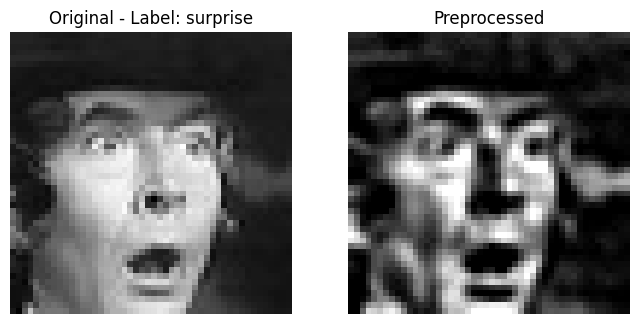

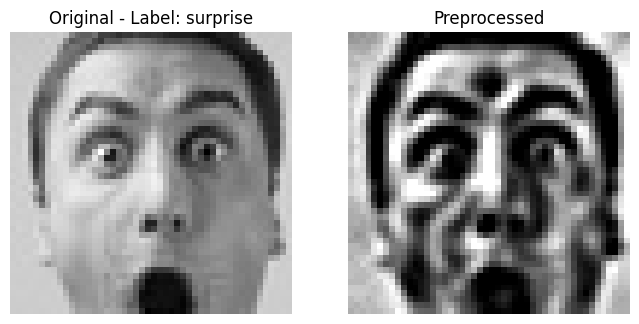

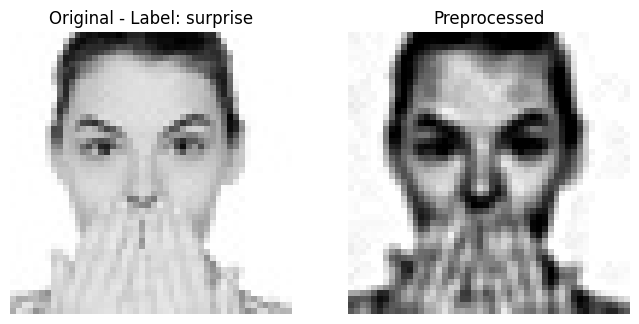

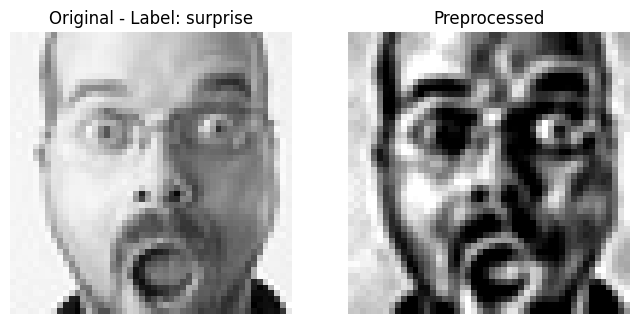

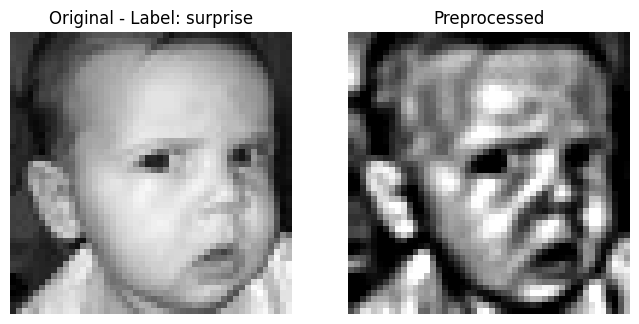

In [ ]:

print("Testing preprocessing comparison on training samples...")
raw_train_images, raw_train_labels = load_raw_images(train_folder)

print("Testing preprocessing comparison on testing samples...")
raw_test_images, raw_test_labels = load_raw_images(test_folder)
test_preprocessing_comparison(raw_test_images, raw_test_labels, num_samples=5)

